핸즈온 7장 <앙상블 학습과 랜덤 포레스트> p.257 - 272

__________________________________________________
# Chapter 7. 앙상블 학습과 랜덤 포레스트
- ### 7.5 부스팅
   - #### 7.5.1 에이다부스트
   - #### 7.5.2 그레이디언트 부스팅
- ### 7.6 스태킹

__________________________________________________

### 7.5 부스팅
[정의]
- **부스팅**(가설 부스팅, boosting, hypothesis boosting) : 약한 학습기를 여러개 연결하여 강한 학습기를 만드는 앙상블 방법. 즉, 앞의 모델을 보완해가면서 일련의 예측기를 학습시킴.

####7.5.1 에이다부스트
[정의]
- **에이다부스트**(adaboost) : 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높임으로써 새로운 예측기가 학습하기 어려운 샘플에 점점 맞춰지도록 보완하는 방식

[특징]
- 학습률을 0.5로 낮췄다는 것은 잘못 분류된 샘플의 가중치를 절반 정도만 높였다는 뜻

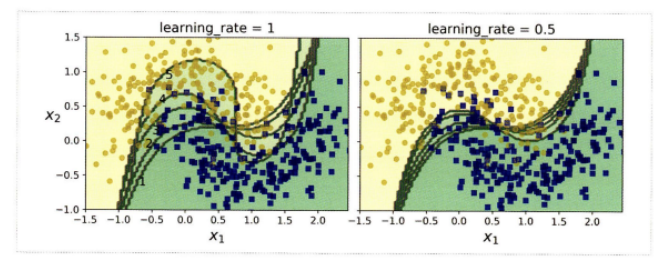

- 모든 예측기가 훈련을 마치면 이 앙상블은 배깅이나 페이스팅과 비슷한 방식으로 예측을 생성.

   BUT, 병렬화는 불가능하므로 배깅이나 페이스팅만큼 확장성이 높진 않음.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import package
import numpy as np
import os

In [3]:
# 5장에서 소개한 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X, y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
# 200개의 얕은 결정 트리를 기반으로 하는 에이다부스트 분류기 훈련
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME", learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

####7.5.2 그레이디언트 부스팅
[정의]
- **그레이디언트 부스팅**(gradient boosting) : 이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습시킴으로써 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가하는 방식
   - gradient tree boosting, gradient boosted regression tree(GBRT)
- **확률적 그레이디언트 부스팅**(stochastic gradient boosting) : subsample 매개변수(훈련 샘플의 비율)를 지정하므로써 편향을 높이고, 분산을 낮추고, 훈련 속도를 높이는 방법
- **축소** 규제방법 : learning_rate 매개변수(각 트리의 기여 정도)를 낮게 설정하는 규제방식. 아래 오른쪽 그림에선 과적합이 보임.

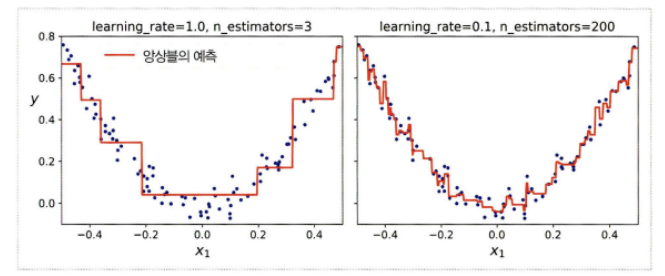

In [9]:
# DecisionTreeRegressor을 훈련 세트에 학습
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [10]:
# 첫번째 예측기에서 생긴 잔여 오차에 두번째 DecisionTreeRegressor 훈련
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [11]:
# 두번째 예측기에서 생긴 잔여 오차에 세번째 DecisionTreeRegressor 훈련
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [ ]:
# 새로운 샘플에 대한 예측 생성
# y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [12]:
# GradientBoostingRegressor로 위와 똑같도록 앙상블 생성
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In [13]:
# 120개의 트리로 GBRT 앙상블을 훈련.
# 최적의 트리의 수를 찾기 위해 staged_predict()를 사용하여 각 훈련 단계에서 검증 오차 측정.
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=114)

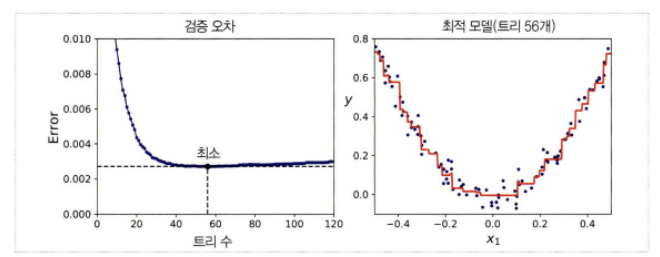

In [14]:
# warm_start=True로 설정하여 연속 다섯번의 반복 동안 검증 오차가 향상되지 않으면 훈련을 멈추는 조기 종료 코드
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1, 120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break # 조기종료

In [15]:
# XGBoost API 확인
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [18]:
# XGBoost의 조기 종료 기능 사용 예시
xgb_reg = xgboost.XGBRegressor(early_stopping_rounds=2)
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)])
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.40757
[1]	validation_0-rmse:0.35051
[2]	validation_0-rmse:0.32568
[3]	validation_0-rmse:0.32031
[4]	validation_0-rmse:0.32478


### 7.6 스태킹
[정의]
- **스태킹**(stacking, stacked generalization) : 각 예측기가 각각 다른 값을 예측하고 블렌더(메타 학습기, 마지막 예측기)가 예측을 입력으로 받아서 최종 예측을 만드는 방식

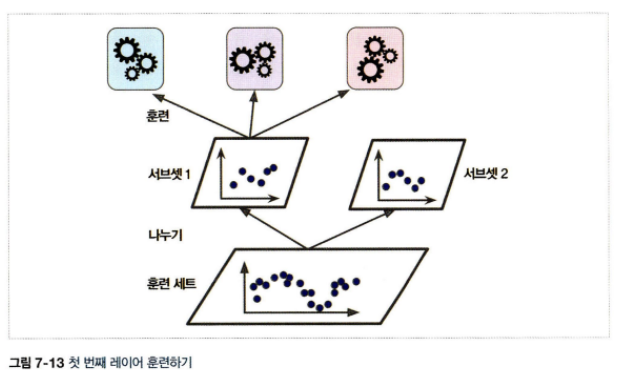

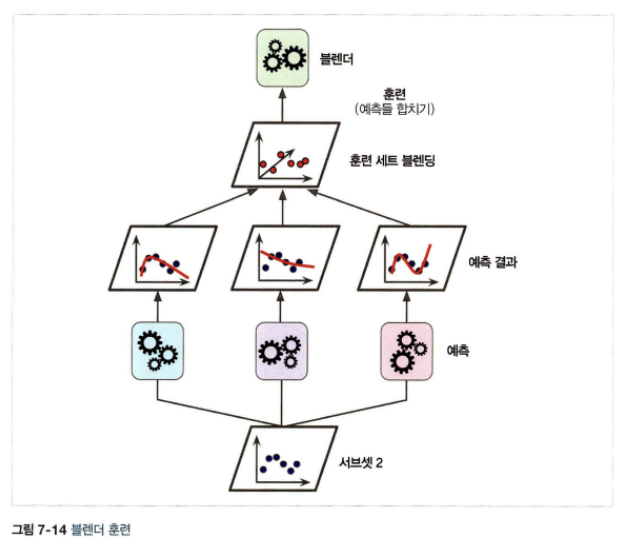

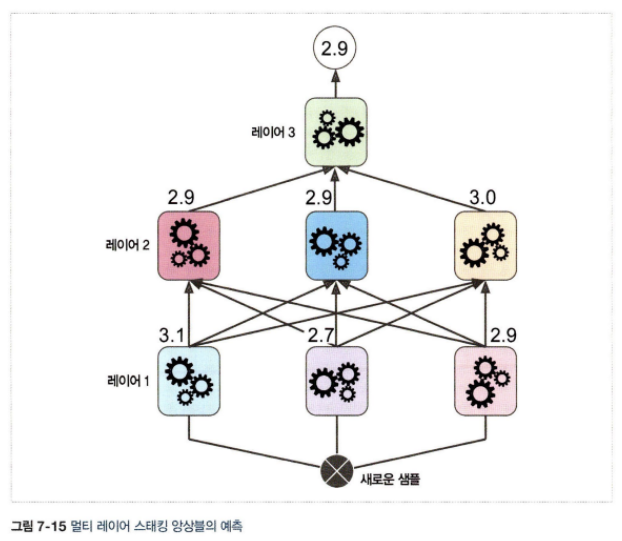